In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline

Задача предсказать тему новости  или рубрику к которой данная новость относится. Для работы был взят файл: lenta.tar.bz2 (https://github.com/buriy/russian-nlp-datasets/releases) .  По сравнению с другими новостными  порталами в этом репозитории,  у lenta.tar.bz2 больше всего разнообразных тем и рубрик, которые можно использовать для  анализа и предсказания в других новостных порталах

Датасет lenta.ru выглядит следующим образом:

In [3]:
data = pd.read_csv('../../../DATASET/lenta.tar.bz2')
print(data.shape)
data.sample(5)

(700006, 6)


,1914-lenta/,url,edition,topics,title,text
3162,2000-01-10 12:00:00,https://lenta.ru/news/2000/01/10/mir/,NaN,Россия,"Космонавты скоро вернутся на ""Мир""","Станция ""Мир"" снова может стать обитаемой. Сов..."
297782,2009-01-21 12:00:00,https://lenta.ru/news/2009/01/21/wheelman/,NaN,Наука и техника,Игра The Wheelman выйдет не раньше марта,Игра The Wheelman поступит в продажу на месяц ...
111281,2005-05-24 12:00:00,https://lenta.ru/news/2005/05/24/fleet/,NaN,Наука и техника,Россия начала подготовку к строительству новой...,Независимой газеты. Министерство обороны пока ...
17403,2000-03-31 12:00:00,https://lenta.ru/news/2000/03/31/hackconf/,NaN,Интернет и СМИ,Съезд хакеров в Израиле: 38% коммерческих сайт...,"Несмотря на повышенные меры контроля, около 35..."
105910,2004-01-06 12:00:00,https://lenta.ru/news/2004/01/06/maher/,NaN,Мир,Глава МИД Египта назвал преждевременной информ...,Заявления иранского руководство о возобновлени...


In [7]:
# удалим столбцы, которые нам не понадобятся и подправим названия 
data.drop(['url','edition','title'],axis=1,inplace=True)
data.rename(columns={'1914-lenta/':'date_of_news'},inplace=True)
data.sample(3)

,date_of_news,topics,text
633484,2017-02-21 12:00:00,Бывший СССР / Белоруссия,В утвержденный Министерством культуры Белорусс...
622478,2017-08-14 12:00:00,Бывший СССР / Украина,Поезд №073/074 Львов — Москва стал лидером по ...
188388,2007-11-19 12:00:00,Россия,Житель Тюмени Антон Гребеньков приговорен к ше...


In [15]:
# Удаляем пустые значения
data.dropna(inplace=True)
data.isnull().any()


date_of_news    False
topics          False
text            False
dtype: bool

In [24]:
data[data.topics == 'topics']

,date_of_news,topics,text
65417,2003-lenta/2003-03-lenta.ru.csv,topics,text


In [27]:
#Удаляем некорректные данные 
data.drop(65417,inplace=True)
data[data.topics == 'topics']


,date_of_news,topics,text


In [28]:
data.shape

(699580, 3)

In [29]:
#Считаем кол-во уникальных тем/рубрик для новостей, которые присутствуют во всем датасете.
data.topics.unique().shape

(124,)

Интересно было как поведут себя модели с таким количеством строк и признаков. Хотелось отобрать наиболее подходящие.  Целевой переменной являлся столбец topics(124 уникальных значения).


Используя только CountVectorizer()  и разные  размеры обучающей и тестовой выборки  получены следующие результаты: (в скобка X_train размер обучающей выборки и кол-во признаков)

Для более понятного восприятия информации из таблицы остановимся чуть более подробно на CountVectorizer()
Если в двух словах, то класс CountVectorizer используется для подготовки текста и создает так называем "мешок слов"(bag-of-words).Создав объект такого класса и применив метод .fit() над текстом мы выполняем следующие действия:
1. Проводим токенизацию т.е разбиваем каждую новость на слова с помощью пробелов и знаков пунктуации
2. Строим из слов(п.1) словарь. Данный словарь содержит все слова которые встречаются во всех новостях. Слова пронумерованы
3. Создаем разряженную матрицу т.е подсчитываем для каждой новости как часто каждое слово из словаря встречается в новости. 
Слово может встречаться несколько раз, а может не встретится ни разу. Поэтому чем больше слов тем больше кол-во признаков.

В таблице ниже представлены следующие данные:

- Время - время обучения модели;
- Размер DF - размер дата фрейма для обучения и тестирования. (Как видно из таблицы при увеличении  объектов и признаков значительно увеличивается время обучения алгоритма, так например LogisticRegression c  X_train (97941x24193) обучается значительно дольше.  )  
- X_test - размер тестовой выборки
- X_train - размер обучающей выборки. (Кол-во объектов,  кол-во признаков).  (это размерность нашей разряженной матрицы для обучения.  Как видно чем больше размер дата фрейма , тем больше объектов и  признаков в X_train)

- min_df -  параметр в CountVectorizer()  который отвечает  за кол-во вхождений конкретного слова в новости. min_df=20  означает что слово будет добавляться в словарь только если оно используется как минимум в 20 новостях. 

Так же сейчас нужно обратить внимание на то, что здесь нет ни каких действий по лемматизации текста, т.е нет приведения слова к его словарной форме. Слова "ехать" и "ехал"  в словаре будут значиться как разные слова.

 

In [40]:
sh1 = pd.read_csv('data/sheet1.csv', )
display((sh1.head(50)))

,Модель,Время,Размер DF,X_test,X_train,TestSize %,min_df,accuracy
0,LogisticRegression,1min 52s,"69 958,00","48 970,60","(20987, 10053)","70,00%",20.0,0.6228
1,LogisticRegression,5min 36s,"69 958,00","34 979,00","(34979, 13591)","50,00%",20.0,0.6431
2,LogisticRegression,>30min,"139 916,00","41 974,80","(97941, 24193)","30,00%",20.0,-
3,-,-,-,-,-,-,-,-
4,RandomForestClassifier,08s,"69 958,00","48 970,60","(20987, 10053)","70,00%",20.0,0.4849
5,RandomForestClassifier,30.7 s,"69 958,00","20 987,40","(48970, 16458)","30,00%",20.0,0.5042
6,RandomForestClassifier,1min 32s,"139 916,00","41 974,80","(97941, 24193)","30,00%",20.0,0.5231
7,-,-,-,-,-,-,-,-
8,LinearSVC,2min 46s,"139 916,00","41 974,80","(97941, 24193)","30,00%",20.0,0.6241
9,LinearSVC,1min 25s,"139 916,00","69 958,00","(69958, 20075)","50,00%",20.0,0.6461



 Для анализа и оценки качества моделей было сделано следующее:
 
 Из всего датасета были отобраны 235 915 статей , которые в колонке topics  содержали как тему так и рубрику например: "Россия/Катастрофы",т.е если у  нас в колонке topics была тема из одного слова например "Россия"или "Украина" она не попала в наш датасет. 

   Из  topics были получены  три столбца: short_topic, short_rubric и topic_rubric.   
   
- в столбец short_topic попала рубрика до '/' из topics.
- в столбец  short_rubric - рубрика после '/'. 
- topic_rubric является копией topics  только без лишних пробелов  возле '/'. 
   
   
Добавлена колонка year_text - обычный текст новости только текст начинается с года и месяца когда данная новость была опубликована. Данные преобразования(добавления года и месяца новости)   были сделаны по следующим причинам: в момент подготовки всего датасета было выявлено, что начиная с 2013 года в новостях lenta.ru  появляются дополнительные рубрики например "Мир/Экономика", соответственно в новостях до 2013 рубрика выглядела как  "Мир". Поэтому чтобы выявить новости без дополнительных рубрик было решено добавить год и месяц новости в начало текста с новостью. В процессе  работы было решено использовать только новости содержащие тему и рубрику, например Мир/Политика или Мир/Преступность. Теоретически год в начале новости был уже не нужен, но качество модели Linear SVC (на тестовой выборке из 42 465 объектов) без года в начале  составляет 0.8721, а с годом - 0.8785. Это на 271 новость с правильно предсказанными темами больше.
И так как работа уже была проделана будем использовать колонку year_text.


Новости были лемматизированы. (pymorphy2)


    
Обработанный датасет был сохранен в отдельный файл.

In [2]:
data = pd.read_csv('../../../DATASET/topici_i_rubrici_go.csv')

In [5]:
# размеры нового файла
data.shape

(235915, 5)

In [34]:
from IPython.display import HTML, display


In [15]:
# Новые  темы  и лемматизированный текст
display(data[['short_topic','short_rubric','topic_rubric','year_text']].sample(5))

,short_topic,short_rubric,topic_rubric,year_text
108478,Интернет и СМИ,Интернет,Интернет и СМИ/Интернет,2016-06 интернет-издание женщина wmj ru сменит...
55224,Экономика,Госэкономика,Экономика/Госэкономика,2014-11 премьер-министр россия дмитрий медведе...
112528,Мир,Политика,Мир/Политика,2016-12 большой половина американский демократ...
139411,Россия,Общество,Россия/Общество,2016-04 рейс авиакомпания аэрофлот который зад...
125039,Бывший СССР,Казахстан,Бывший СССР/Казахстан,2016-01 двое житель казахский город кустанай о...


Если посмотреть на количество уникальных тем  в каждом столбце мы получим следущую картину:

In [36]:

print (f'уникальных тем short_topic:  {data.short_topic.unique().shape[0]}')
print (f'уникальных тем short_rubric: {data.short_rubric.unique().shape[0]}')
print (f'уникальных тем topic_rubric:  {data.topic_rubric.unique().shape[0]}')

уникальных тем short_topic:  18
уникальных тем short_rubric: 89
уникальных тем topic_rubric:  104


Ну и соответсвенно сами темы:


In [37]:
sorted(data.short_topic.unique())

['69-я параллель',
 'Библиотека',
 'Бизнес',
 'Бывший СССР',
 'Из жизни',
 'Интернет и СМИ',
 'Культпросвет',
 'Культура',
 'Легпром',
 'Мир',
 'Наука и техника',
 'Оружие',
 'Путешествия',
 'Россия',
 'Силовые структуры',
 'Спорт',
 'Ценности',
 'Экономика']

In [38]:
sorted(data.short_rubric.unique())


['Coцсети',
 'Авто',
 'Автобизнес',
 'Аналитика рынка',
 'Белоруссия',
 'Бизнес',
 'Бокс и ММА',
 'Вещи',
 'Вирусные ролики',
 'Вкусы',
 'Внешний вид',
 'Вооружение',
 'Выборы',
 'Гаджеты',
 'Госрегулирование',
 'Госэкономика',
 'Движение',
 'Деловой климат',
 'Деньги',
 'Достижения',
 'Еда',
 'Жизнь',
 'Звери',
 'Зимние виды',
 'Игры',
 'Инновации',
 'Инструменты',
 'Интернет',
 'Искусство',
 'История',
 'Кавказ',
 'Казахстан',
 'Катастрофы',
 'Киберпреступность',
 'Кино',
 'Книги',
 'Конфликты',
 'Космос',
 'Криминал',
 'Крым',
 'Культпросвет',
 'Летние виды',
 'Люди',
 'Мемы',
 'Мир',
 'Мировой бизнес',
 'Мировой опыт',
 'Мнения',
 'Молдавия',
 'Москва',
 'Музыка',
 'Наследие',
 'Наука',
 'ОИ-2018',
 'Общество',
 'Оружие',
 'Первая мировая',
 'Политика',
 'Полиция и спецслужбы',
 'Пресса',
 'Преступная Россия',
 'Преступность',
 'Прибалтика',
 'Производители',
 'Происшествия',
 'Регионы',
 'Реклама',
 'Россия',
 'Рынки',
 'Следствие и суд',
 'События',
 'Софт',
 'Социальная сфера',


In [39]:
sorted(data.topic_rubric.unique())

['69-я параллель/Достижения',
 '69-я параллель/История',
 '69-я параллель/Люди',
 '69-я параллель/События',
 '69-я параллель/Туризм',
 '69-я параллель/Экология',
 '69-я параллель/Явления',
 'Библиотека/Первая мировая',
 'Бизнес/Автобизнес',
 'Бизнес/Бизнес',
 'Бизнес/Деловой климат',
 'Бизнес/Мировой бизнес',
 'Бизнес/Финансы компаний',
 'Бывший СССР/Белоруссия',
 'Бывший СССР/Кавказ',
 'Бывший СССР/Казахстан',
 'Бывший СССР/Молдавия',
 'Бывший СССР/Прибалтика',
 'Бывший СССР/Средняя Азия',
 'Бывший СССР/Украина',
 'Из жизни/Вещи',
 'Из жизни/Достижения',
 'Из жизни/Еда',
 'Из жизни/Звери',
 'Из жизни/Люди',
 'Из жизни/Происшествия',
 'Из жизни/События',
 'Интернет и СМИ/Coцсети',
 'Интернет и СМИ/Вирусные ролики',
 'Интернет и СМИ/Интернет',
 'Интернет и СМИ/Киберпреступность',
 'Интернет и СМИ/Мемы',
 'Интернет и СМИ/Пресса',
 'Интернет и СМИ/Реклама',
 'Интернет и СМИ/ТВ и радио',
 'Культпросвет/Наследие',
 'Культпросвет/События',
 'Культпросвет/Туризм',
 'Культура/Искусство',
 'Кул

Теперь у нас есть три категории тем. Начнем с short_topic

In [9]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from datetime import datetime


In [21]:
X = data[['short_topic','year_text']]
y=X.pop('short_topic')
X.shape,y.shape

((235915, 1), (235915,))

In [22]:
# Эта функция  разбивает X и y  на обучающую и тестовую выборки.
#Создает объект CountVectorizer(), который  обучается  на (X_train) с помощью метода .fit() 
# с помощью метода .transform()  мы преобразуем обучающую и тестовую выборки
# Так же здесь в метод CountVectorizer() передается параметр ngram_range, о котором не говорилось ранее. 

def vector_and_massiv(X,y,min_df,test_size=.18):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=test_size,random_state=42,shuffle=True)
    vect = CountVectorizer(min_df = min_df,ngram_range=(1,2))
    vect.fit(X_train.iloc[:,0])
    X_vect_train = vect.transform(X_train.iloc[:,0])
    X_vect_test = vect.transform(X_test.iloc[:,0])
    return X_vect_train,X_vect_test,y_train,y_test

In [29]:

%%time
X_vect_train,X_vect_test,y_train,y_test = vector_and_massiv(X,y,min_df=40)

CPU times: user 4min 10s, sys: 4.05 s, total: 4min 14s
Wall time: 4min 15s


In [30]:
# Используя ngram_range =(1,2) мы получили намного больше  признаков 
X_vect_train.shape, X_vect_test.shape

((193450, 90626), (42465, 90626))


Дальше приводятся примеры и делаются выводы на результатах алгоритма  LinearSVC, так как он довольно быстро обрабатывает большой объем информации и дает неплохой результат. Результаты  работы других алгоритмов будут приведены ниже.

In [31]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)

In [32]:
%%time
svc.fit(X_vect_train,y_train)

CPU times: user 1min 26s, sys: 287 ms, total: 1min 27s
Wall time: 1min 27s


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [33]:
pred=svc.predict(X_vect_test)
accuracy_score(y_test,pred)

0.8785823619451313

In [34]:
# Сформируем  отчет
from sklearn.metrics import classification_report
print(classification_report(y_test,pred,digits=2));


                   precision    recall  f1-score   support

   69-я параллель       0.88      0.75      0.81       199
       Библиотека       1.00      0.85      0.92        13
           Бизнес       0.82      0.73      0.77      1327
      Бывший СССР       0.91      0.91      0.91      4061
         Из жизни       0.81      0.76      0.79      1947
   Интернет и СМИ       0.83      0.80      0.82      2862
     Культпросвет       0.62      0.29      0.39        52
         Культура       0.90      0.92      0.91      3250
          Легпром       0.78      0.70      0.74        10
              Мир       0.89      0.92      0.90      7021
  Наука и техника       0.92      0.92      0.92      3075
           Оружие       0.00      0.00      0.00         1
      Путешествия       0.88      0.84      0.86      1096
           Россия       0.84      0.86      0.85      7384
Силовые структуры       0.81      0.76      0.79      1865
            Спорт       0.97      0.98      0.97      3

Данный отчет  отображает точность(precision), полноту(recall) и F-меру(F-score). Три важных метрики качества.  
Немного остановимся на данных метриках. Для этого сформируем матрицу ошибок и покажем данные метрики на примере.

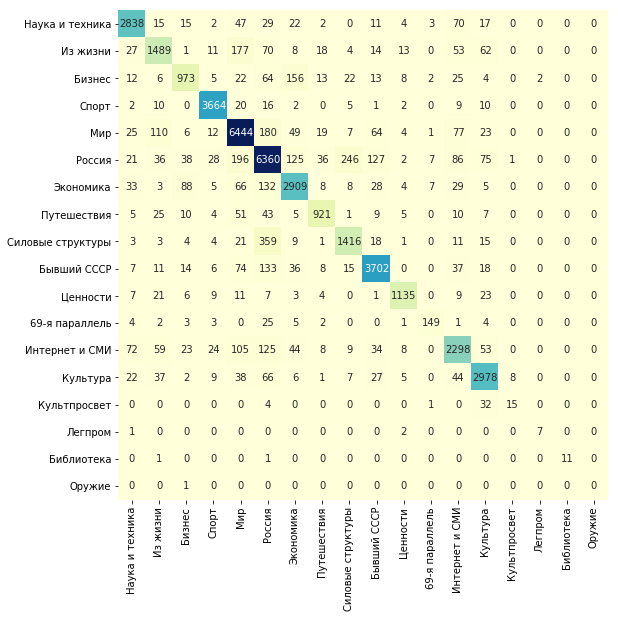

In [35]:
# сформирум матрицу ошибок чтобы более наглядно посмотреть на каких метках наш алгоритм ошибается чаще всего.
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test,pred,labels=y_test.unique())
plt.figure(figsize=(9, 9))

sns.heatmap(mat,square=True,annot=True,cbar=False,cmap="YlGnBu",fmt='d',xticklabels=y_test.unique(), yticklabels=y_test.unique());

если воспользоваться формулами то:
- precision(точность) = True_Positive /(True_Positive +False_Positive) 

где  True_Positive- это  значение на пересечении одинаковых меток, а True_Positive + False_Positive -  это сумма значений соответствующего столбца. 
  True_Positive -  мы верно предсказали нужную метку.
  False_Positive - мы другие метки предсказали как нужные нам.
 
- recall(полнота) = True_Positive /(True_Positive +False_Negative)

где  True_Positive- это  так же значение на пересечении одинаковых меток, а True_Positive + False_Negative -  это сумма значений соответствующей строки

False_Negative - мы нужную нам метку предсказали как другие.

- F-score = 2* (precision * recall) / (precision + recall) 


F- score представляет собой среднее между точностью и полнотой, но ее труднее интерпретировать объяснить

для примера возьмем метку "Культпросвет"
для данной метки:
- True_Positive = 15 (на пересении "Культпросвет" х "Культпросвет")
- False_Negative = 37 (строка  "Культпросвет" (4 + 1 + 32 = 37) )
- False_Positive = 9 (столбец "Культпросвет" 8 + 1 = 9)

Подставим все данные в формулы: 

- precision = 15 /(15+9) = 0.62
- recall = 15/ (15+37) = 0.29

Вот мы и получили значения для метки "Культпросвет" которые были в classification_report

 Есть метки которые очень похожи по смыслу и ожидаемо, что  алгоритм на них ошибается. Например "Бизнес-Экономика", "Культпросвет - Культура". А есть непохожие, но почему то алгоритм часто на них ошибается. Например "Силовые структуры - Россия". Всего меток силовые структуры 1865 из них 246 были классифицированы как Россия -около 13%. Попробуем разобраться почему.



In [36]:
X_for_test = data[['short_topic','year_text']]
_,X_test =  train_test_split(X_for_test, test_size=.18,random_state=42,shuffle=True)
del X_for_test


In [37]:
X_test['predict'] = pred 

In [38]:
X_test.sample(10)

,short_topic,year_text,predict
108783,Экономика,2016-12 новый глава минэкономразвития максим о...,Экономика
42152,Наука и техника,2014-07 группа астроном использовать дать акус...,Наука и техника
37657,Культура,2014-09 исполнитель главный роль маньяк-убийца...,Культура
25043,Мир,2013-06 полиция применить слезоточивый газ вод...,Мир
22607,Россия,2013-09 столица республика саха местный житель...,Бывший СССР
74656,Спорт,2015-07 главный тренер петербургский ска андре...,Спорт
165791,Россия,2017-09 полигон ленинградский область взорвать...,Россия
34892,Культура,2014-02 эмма уотсон сняться триллер алехандро ...,Культура
209130,Экономика,2017-07 рост несырьевой экспорт россия данный ...,Экономика
95940,Россия,2015-03 ряд реконструировать стадион динамо пл...,Спорт


Идея в следующем отобрать рубрики которые совпали и которые нет. посмотреть почему

Отберем три датафрейма. 

In [42]:
X_bis_econom = X_test [(X_test.short_topic == 'Бизнес') & (X_test.predict == 'Экономика') ]

X_bis_econom.sample(5)

,short_topic,year_text,predict
212122,Бизнес,2017-07 китайский нефтегазовый компания petroc...,Экономика
86264,Бизнес,2015-12 апелляционный суд париж отказаться при...,Экономика
186960,Бизнес,2017-06 зампред правление газпром александр ме...,Экономика
152615,Бизнес,2016-02 exxonmobil bp договориться снять дейст...,Экономика
186130,Бизнес,2017-01 россия система tax free пилотный проек...,Экономика


In [44]:
print (X_bis_econom.shape)

(156, 3)


Напишем небольшую функцию которая принимает наш датасет для анализа и n_words(сколько популярных слов показать на экране. По умолчанию 30). Затем выводит на экран список из самых популярных слов, соответствующийх данной теме  и кол-во сколько раз  каждое слово упоминается в новостях с данной темой.

In [117]:
def count_words (X,n_words=30):
    
    counVect = CountVectorizer()  
    X_bis_eco_vect = counVect.fit_transform (X.year_text)#   создаем  разряженную матрицу  из слов
    vocab_features_names = list(counVect.get_feature_names())# получаем список всех слов
    count_words = X_bis_eco_vect.sum(axis=0).A1 #  сумируем значения по каждому столбцу и сплющиваем матрицу
    freq_distribution = Counter(dict(zip(vocab_features_names, count_words)))# создаем словарь из слов и повторений  
    print (freq_distribution.most_common(n_words))# выводим на печать
                            

In [122]:
count_words(X_bis_econom,20)

[('год', 481), ('это', 343), ('россия', 292), ('компания', 289), ('доллар', 226), ('процент', 225), ('миллиард', 206), ('российский', 192), ('рубль', 158), ('который', 154), ('миллион', 145), ('цена', 140), ('нефть', 124), ('2015', 123), ('рынок', 114), ('2016', 111), ('страна', 105), ('2014', 93), ('заявить', 92), ('также', 91)]


In [123]:
X_econom = X_test [(X_test.short_topic == 'Экономика') & (X_test.predict == 'Экономика') ]

X_econom.sample(5)

,short_topic,year_text,predict
134778,Экономика,2016-11 неразведанный потенциал углеводород ар...,Экономика
93114,Экономика,2015-02 официальный курс евро установленный це...,Экономика
160291,Экономика,2016-10 банк россия повысить официальный курс ...,Экономика
64670,Экономика,2015-08 курс доллар московский биржа вырасти с...,Экономика
180933,Экономика,2017-12 биткоина являться башня смерть инвесто...,Экономика


In [124]:
X_econom.shape

(2909, 3)

In [125]:
count_words(X_econom,20)

[('год', 8899), ('процент', 5671), ('это', 5346), ('россия', 4659), ('рубль', 4316), ('доллар', 3665), ('миллиард', 3001), ('который', 2913), ('компания', 2885), ('российский', 2235), ('страна', 2029), ('также', 1913), ('цена', 1753), ('заявить', 1690), ('миллион', 1638), ('мочь', 1559), ('нефть', 1509), ('2016', 1465), ('2014', 1442), ('рынок', 1382)]


In [135]:
X_econom_bis = X_test [(X_test.short_topic == 'Экономика') & (X_test.predict == 'Бизнес') ]
X_econom_bis.shape

(88, 3)

In [128]:
count_words(X_econom_bis,20)

[('год', 300), ('компания', 198), ('это', 172), ('россия', 150), ('процент', 139), ('российский', 109), ('рубль', 96), ('который', 93), ('миллиард', 84), ('доллар', 72), ('тысяча', 72), ('2017', 66), ('проект', 66), ('2015', 60), ('также', 60), ('роснефть', 55), ('заявить', 54), ('2016', 51), ('миллион', 51), ('рынок', 48)]


Не удивительно что алгоритм ошибается на данных темах. Посмотрим что с темами "Россия-Силовые структуры"

In [136]:
X_rus_power = X_test [(X_test.short_topic == 'Россия') & (X_test.predict == 'Силовые структуры') ]

X_rus_power.shape

(246, 3)

In [134]:
count_words(X_rus_power,20)#

[('год', 379), ('это', 313), ('дело', 276), ('который', 222), ('россия', 188), ('суд', 174), ('уголовный', 171), ('сотрудник', 156), ('задержать', 151), ('также', 147), ('мужчина', 135), ('следственный', 135), ('человек', 127), ('сообщать', 126), ('рубль', 124), ('следствие', 117), ('убийство', 115), ('свой', 113), ('сообщить', 111), ('возбудить', 110)]


In [137]:
X_power = X_test [(X_test.short_topic == 'Силовые структуры') & (X_test.predict == 'Силовые структуры') ]

X_power.shape

(1416, 3)

In [138]:
count_words(X_power,20)

[('год', 2658), ('это', 1914), ('дело', 1879), ('который', 1326), ('суд', 1311), ('россия', 1232), ('уголовный', 1142), ('задержать', 1081), ('следствие', 986), ('сообщить', 982), ('рубль', 941), ('следственный', 818), ('убийство', 815), ('сотрудник', 806), ('москва', 783), ('также', 772), ('управление', 732), ('статья', 726), ('2016', 712), ('миллион', 680)]


In [139]:
X_rus = X_test [(X_test.short_topic == 'Россия') & (X_test.predict == 'Россия') ]
X_rus.shape

(6360, 3)

In [140]:
count_words(X_rus,20)

[('это', 9993), ('год', 8645), ('россия', 7172), ('который', 6682), ('человек', 4139), ('также', 3720), ('президент', 3656), ('москва', 3481), ('свой', 3380), ('глава', 3285), ('заявить', 3248), ('сообщать', 3080), ('весь', 2991), ('слово', 2938), ('российский', 2918), ('время', 2818), ('область', 2581), ('дело', 2469), ('путин', 2419), ('сообщить', 2389)]


In [141]:
X_power_rus = X_test [(X_test.short_topic == 'Силовые структуры') & (X_test.predict == 'Россия') ]
X_power_rus.shape

(359, 3)

In [145]:
count_words(X_power_rus,20)

[('это', 460), ('год', 458), ('который', 354), ('дело', 314), ('россия', 245), ('человек', 244), ('уголовный', 226), ('суд', 212), ('сообщить', 202), ('полиция', 186), ('мужчина', 182), ('москва', 177), ('также', 172), ('управление', 168), ('статья', 167), ('задержать', 164), ('следственный', 163), ('сотрудник', 160), ('произойти', 159), ('орган', 158)]


В теме "Россия" есть разные новости, и часть из них похожа для алгоритма (и, вероятно, для человека) на типичные новости темы "Силовые структуры". А если взять популярные слова для этих групп, то наборы этих слов почти совпадают.
Часто такое возникает из-за низкого качества или неоднозначности ручной разметки.
Таким образом, алгоритм исправляет часть ошибок ручной разметки.  

Теперь рассмотрим как поведет себя алгоритм если мы увеличим количество тем 

In [202]:
X = data[['short_rubric','year_text']]
y=X.pop('short_rubric')
y.unique().shape

(89,)

Так же создаем разряженные матрицы тестовой и обучающей выборки, но уже с большим количеством уникальных значений нашей целевой переменной

In [203]:
%%time
X_vect_train,X_vect_test,y_train,y_test = vector_and_massiv(X,y,min_df=40)

CPU times: user 4min 15s, sys: 3.47 s, total: 4min 18s
Wall time: 4min 20s


In [151]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)

In [204]:
%%time
svc.fit(X_vect_train,y_train)

CPU times: user 4min 30s, sys: 343 ms, total: 4min 30s
Wall time: 4min 31s


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [205]:
pred=svc.predict(X_vect_test)
accuracy_score(y_test,pred)

0.7264570823030732

In [206]:
from sklearn.metrics import classification_report
print (classification_report(y_test,pred,digits=2))

                      precision    recall  f1-score   support

             Coцсети       0.60      0.57      0.58       496
                Авто       0.72      0.81      0.76        16
          Автобизнес       0.71      0.62      0.67        56
     Аналитика рынка       0.60      0.75      0.67         4
          Белоруссия       0.86      0.80      0.83       162
              Бизнес       0.64      0.68      0.66      1402
          Бокс и ММА       0.95      0.95      0.95       386
                Вещи       0.37      0.19      0.25        69
     Вирусные ролики       0.53      0.41      0.46        88
               Вкусы       0.00      0.00      0.00        10
         Внешний вид       0.75      0.72      0.74        94
          Вооружение       0.00      0.00      0.00         1
              Выборы       0.00      0.00      0.00         1
             Гаджеты       0.76      0.79      0.78       367
    Госрегулирование       0.50      0.33      0.40         3
       

Если посмотреть на этот отчет то  видно что есть новости с темы например как "Страноведение" для которых алгоритм вообще не может предсказать метку. Если использовать эти метки для предсказания то нужно  проанализировать отчет и заменить/удалить метки которые малозначимые. Например "Производители", "ЧМ-2018", "Фотография"  и т.п.

Построить матрицу ошибок с таким количеством меток можно построить но нельзя будет ничего понять. Поэтому  мы построим матрицу на части наших данных. Построим несколько  матриц 30Х30

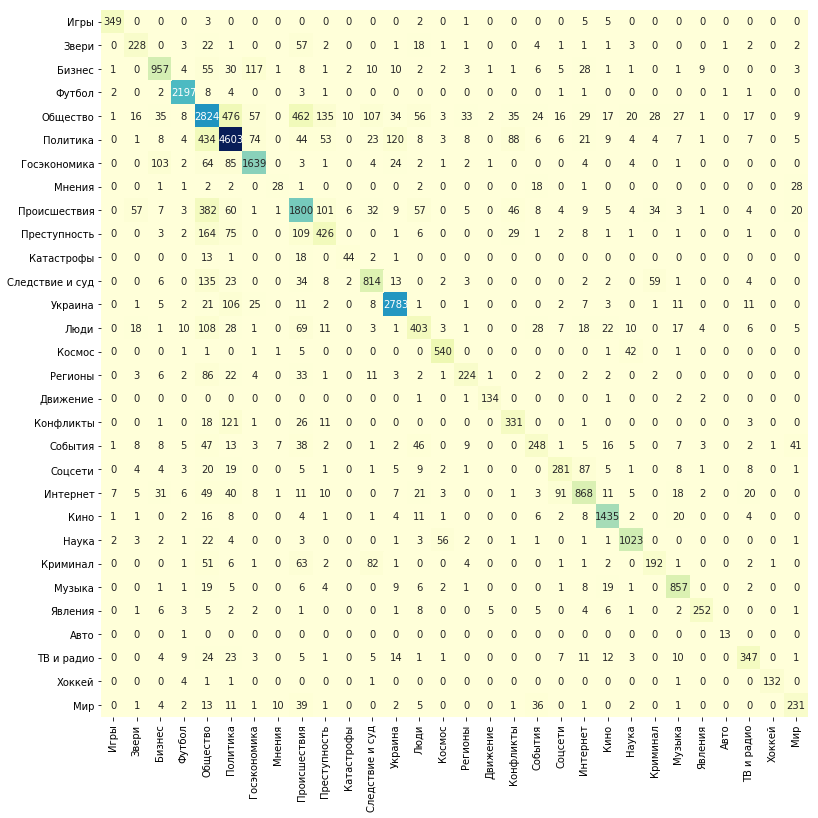

In [207]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test,pred,labels=y_test.unique())
plt.figure(figsize=(13, 13))

sns.heatmap(mat[:30,:30],square=True,annot=True,
            cbar=False,cmap="YlGnBu",fmt='d',
            xticklabels=y_test.unique()[:30],
            yticklabels=y_test.unique()[:30]);

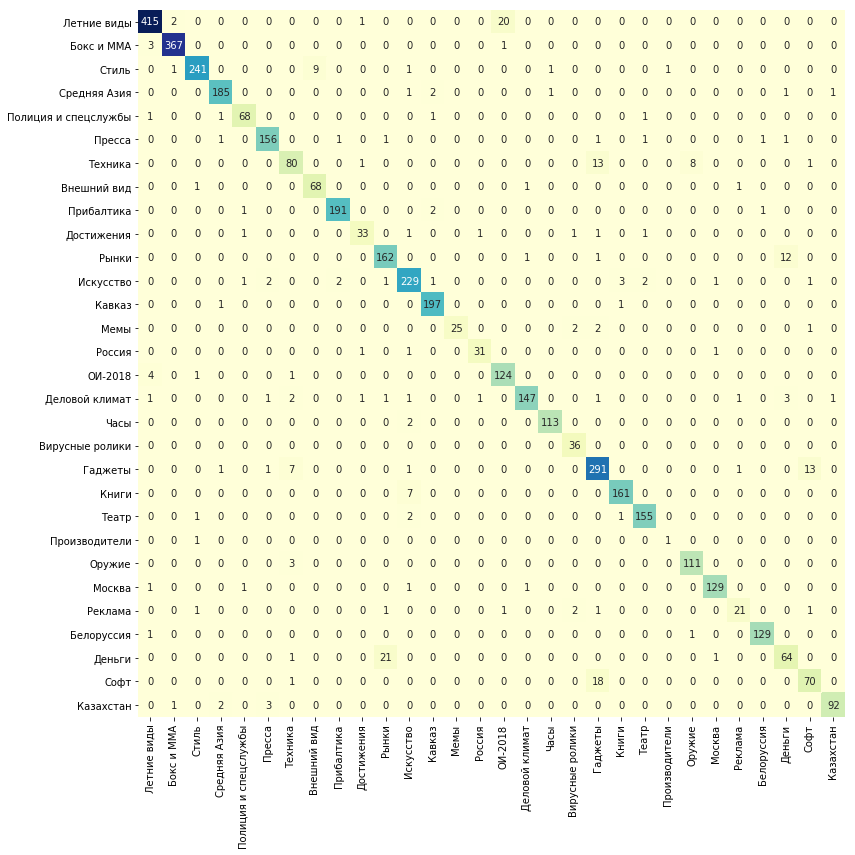

In [208]:
plt.figure(figsize=(13, 13))

sns.heatmap(mat[30:60,30:60],square=True,annot=True,
            cbar=False,cmap="YlGnBu",fmt='d',
            xticklabels=y_test.unique()[30:60],
            yticklabels=y_test.unique()[30:60]);

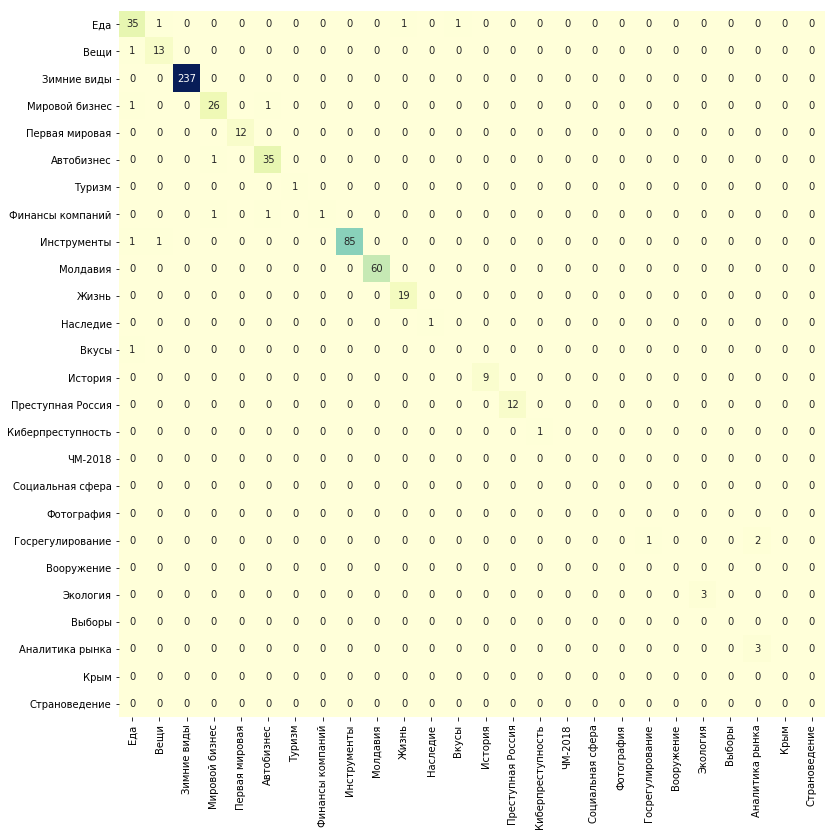

In [209]:
plt.figure(figsize=(13, 13))

sns.heatmap(mat[60:90,60:90],square=True,annot=True,
            cbar=False,cmap="YlGnBu",fmt='d',
            xticklabels=y_test.unique()[60:90],
            yticklabels=y_test.unique()[60:90]);

Как видно больше всего ошибок возникает на первой матрице. Такие  группа тем как (Общество, Политика, Происшествия,Преступность), а так же группа (Происшествия, Преступность)  очень похожи для алгоритма и он ошибается на них больше всего.Если объединить похожие рубрики, то качество работы алгоритма  улучшиться. Для пример у нас всего  833 метки с темой "Преступность", но правильно мы предсказываем только половину. И у нас ест  темы: "полиция и спец службы", "криминал" которые похожи. Есть темы "Происшествия" и "Катастрофы".   

Посмотрим что будет на третей группе целевых меток

In [210]:
X = data[['topic_rubric','year_text']]
y=X.pop('topic_rubric')
y.unique().shape

(104,)

In [211]:
%%time
X_vect_train,X_vect_test,y_train,y_test = vector_and_massiv(X,y,min_df=40)

CPU times: user 4min 14s, sys: 3.89 s, total: 4min 18s
Wall time: 4min 19s


In [212]:
%%time
svc.fit(X_vect_train,y_train)

CPU times: user 5min 1s, sys: 287 ms, total: 5min 1s
Wall time: 5min 1s


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [213]:
pred=svc.predict(X_vect_test)
accuracy_score(y_test,pred)

0.7208289179324149

Качество упало на 0,006.

Построим матрицу ошибок 35Х35

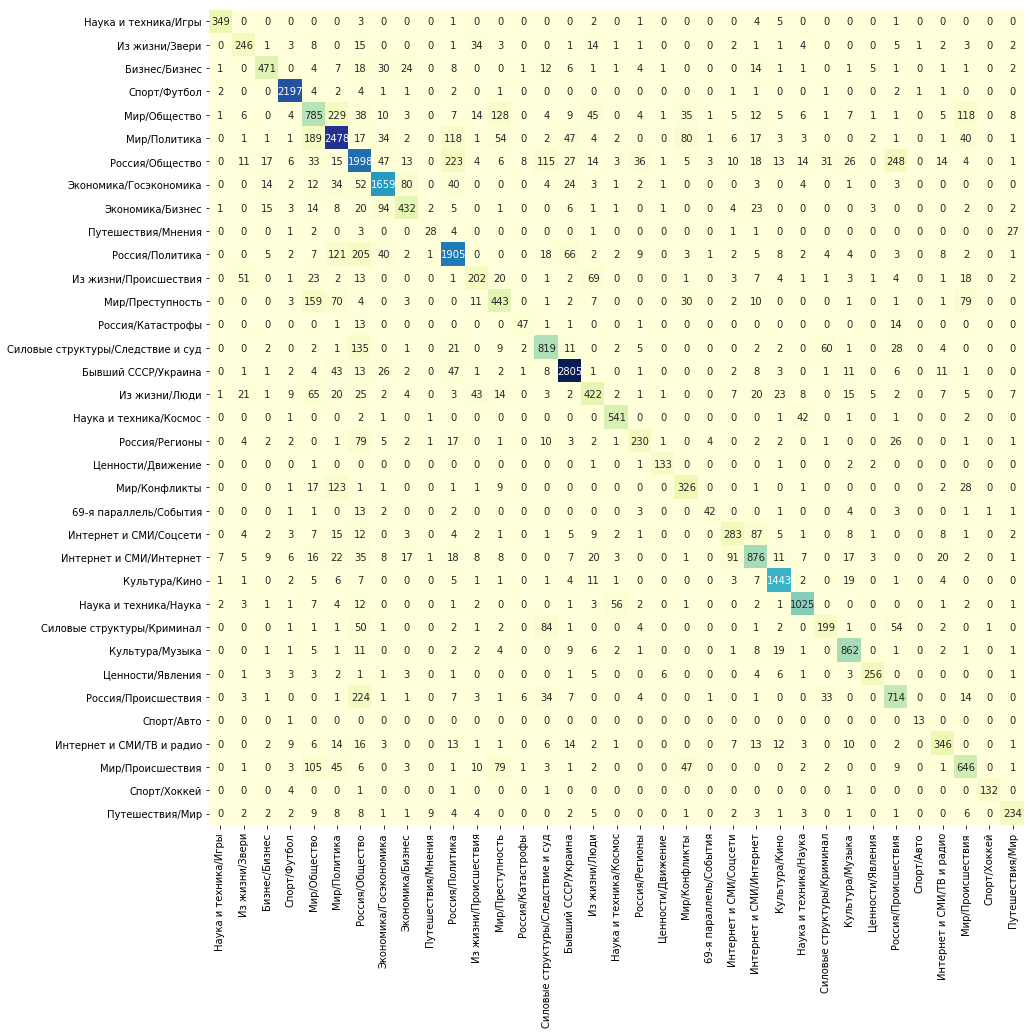

In [214]:
mat = confusion_matrix(y_test,pred,labels=y_test.unique())
plt.figure(figsize=(15, 15))

sns.heatmap(mat[:35,:35],square=True,annot=True,
            cbar=False,cmap="YlGnBu",fmt='d',
            xticklabels=y_test.unique()[:35],
            yticklabels=y_test.unique()[:35]);


Здесь мы видим  самые большие ошибки алгоритма на темах "Россия/Политика- Россия /Общество", "Мир/Политика- Мир/Общество"

In [224]:
#Последняя строчка отчета. Показывает точность, полноту и F- меру. 

print (classification_report(y_test,pred,digits=2)[-2980:])

    0.00        10
                       Путешествия/Мир       0.60      0.62      0.61       375
                    Путешествия/Мнения       0.47      0.31      0.37        91
              Путешествия/Происшествия       0.67      0.66      0.67       176
                    Путешествия/Россия       0.42      0.24      0.30       118
                   Путешествия/События       0.67      0.62      0.64       326
                     Россия/Катастрофы       0.71      0.59      0.65        79
                           Россия/Крым       0.00      0.00      0.00         1
                         Россия/Москва       0.63      0.58      0.60       233
                       Россия/Общество       0.60      0.65      0.62      3078
                       Россия/Политика       0.75      0.77      0.75      2490
                   Россия/Происшествия       0.59      0.66      0.62      1088
                        Россия/Регионы       0.70      0.55      0.62       415
            Силовые с

Как мы можем видеть мы получил совсем не плохие результаты при условии что у нас было 104 метки. Метки более разнообразные  и намного лучше отражают смысл новости. Если их привести в порядок (т.е объединить похожие темы), то определившись с темами можно будет обучить алгоритм и предсказать темы для других новостных порталов.

А сейчас посмотрите на результаты работы других алгоритмов:

In [270]:
table2=pd.read_csv('data/sheet3.csv')

In [271]:
table2

,№,Модель,Время,Качество,Параметры,Примечание
0,1.0,LinearSVC,43.1 s,0.8755,C=0.001,y=topics(18)
1,2.0,LinearSVC,1min 11s,0.8785,C=0.01,y=topics(18)
2,3.0,LinearSVC,2min 45s,0.8651,C=0.1,y=topics(18)
3,-,-,-,-,-,-
4,4.0,LinearSVC,4min 1s,0.7308,C=0.001,y=rubric(89)
5,5.0,LinearSVC,4min 15s,0.7264,C=0.01,y=rubric(89)
6,6.0,LinearSVC,11min 33s,0.6988,C=0.1,y=rubric(89)
7,-,-,-,-,-,-
8,1.0,MLPClassifier,46min 59s,0.8662,alpha=0.0001,y=topics(18)
9,-,-,-,-,-,-


Fasttext быстрее всего справляется с поставленной задачей и дает отличный результат, но в силу того что подготовка  текста для использования метода supervised() немного специфическая  и отличается от привычного способа, а результаты почти совпадают с Linear SVC, то для анализа был выбран метод LinearSVC.

Базы данных для экспериментов доступны по ссылке https://drive.google.com/open?id=1KdLtnKqJLp3LG-qWgfnaLhKpYxyghuhX